In [1]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, \
                            accuracy_score,precision_score, recall_score, f1_score, \
                            confusion_matrix, ConfusionMatrixDisplay
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Read in  Data:

In [2]:
df = pd.read_csv('./Data/cat_clean.csv')

In [3]:
df.describe()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem
count,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000,5696.000000
mean,4.752602,1.539326,0.779670,4.619031,2.547753,0.847788,3.770190,4.088834,1.116397,1.096559,1.583743,2.025632,1.884480,1.789150,0.912395,1.070400
std,3.768478,0.498495,0.414506,1.576234,1.911887,0.359258,0.864699,0.878686,0.418163,0.368394,0.839547,0.996769,1.051775,0.997606,1.544499,0.384687
min,0.167100,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.789000,1.000000,1.000000,4.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
50%,3.886300,2.000000,1.000000,4.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000
75%,6.778100,2.000000,1.000000,5.000000,5.000000,1.000000,4.000000,5.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1.000000
max,24.811000,2.000000,1.000000,8.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,7.000000,3.000000


**Notes:**  
* I'm not sure if I will scale the age column for my distance-based classifiers. I feel like doing so will lose an aspect of interpretability if the goal here is to be able to predict if a cat you're going to adopt would be a wool-sucker or not. However, I do understand the importance of magnitiude in algorithms of that nature. 
* I am going to reocde `Behaviour_problem` as a binary of yes or no (compared to I don't know, no, yes dx'd by vet, yes dx'd by self). 
* I will try to do both multiclass and binary classification with wool sucking but I fear I won't have enough data to get much worth out of a multiclass classifier.
* I will try three flavors of logistic regression (binary, multiclass, ordinal). Two of random forest (binary, multiclass). And four KNN (binary, binary with age scaled, multiclass, multiclass with age scaled). 

# Preprocessing and Feature Engineering:

In [4]:
# Recode Behaviour_problem to binary
df['Behaviour_problem'].replace([1, 2, 3], [0, 1, 1], inplace=True)
df['Behaviour_problem'].value_counts()

0.0    5200
1.0     496
Name: Behaviour_problem, dtype: int64

In [5]:
# BINARY DATA SET
df_bin = df.copy()
# 0-2 = no sucking, 3-7 = sucking 
df_bin['ws_binary'] = df_bin['Wool_sucking'].replace({1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1})
df_bin.drop(columns='Wool_sucking', inplace=True)
df_bin.head()

# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
df_bin = pd.get_dummies(df_bin, columns=['Breed_group'], prefix='B')
df_bin[['ws_binary', 'B_MCO']].describe()

,ws_binary,B_MCO
count,5696.000000,5696.000000
mean,0.252282,0.055829
std,0.434361,0.229611
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [6]:
# Assign BINARY X and y
X_bin = df_bin.drop(columns='ws_binary')
y_bin = df_bin['ws_binary']

In [7]:
# MULTICLASS DATA SET 
df_multi = df.copy()

# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
df_multi = pd.get_dummies(df_multi, columns=['Breed_group'], prefix='B')
df_multi[['Wool_sucking', 'B_MCO']].describe()

,Wool_sucking,B_MCO
count,5696.000000,5696.000000
mean,0.912395,0.055829
std,1.544499,0.229611
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,7.000000,1.000000


In [8]:
# Assign MULTICLASS X and y
X_multi = df_multi.drop(columns='Wool_sucking')
y_multi = df_multi['Wool_sucking']

In [9]:
# I already know y has some serious class imablance for my wool-suckers, hence stratify
# binary train/test split
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin)

# multiclass train/test split 
X_trains, X_tests, y_trains, y_tests = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi)

### Checking for multicollinearity:

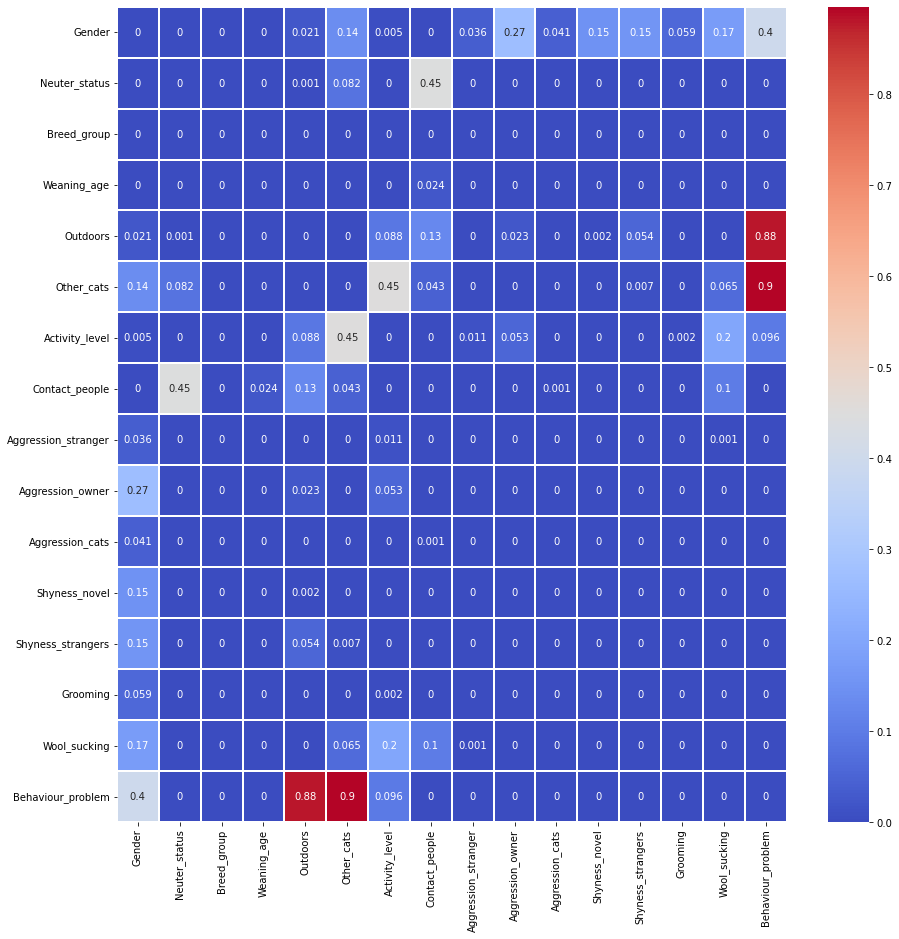

In [10]:
# extract column names
columns = df.drop(columns='Age').columns 
    
# create matrix 
chisqmatrix = pd.DataFrame(df.drop(columns='Age'), columns=columns, index=columns)
   
# set counters to 0
outercnt=0
innercnt=0
for icol in columns: # outer loop
    for jcol in columns: # inner loop
        crosstab = pd.crosstab(df[icol], df[jcol])
        stat, p, dof, expected = stats.chi2_contingency(crosstab)
        chisqmatrix.iloc[outercnt,innercnt]=round(p,3)
        cntexpected=expected[expected<5].size
        perexpected=((expected.size-cntexpected)/expected.size)*100
      
       
        if perexpected<20:
            chisqmatrix.iloc[outercnt,innercnt]=2 # low count between them suggests p-value is unreliable, do not use 
        if icol==jcol:
            chisqmatrix.iloc[outercnt,innercnt]=0.00
        innercnt=innercnt+1
    outercnt=outercnt+1
    innercnt=0

plt.subplots(figsize=(15, 15))
sns.heatmap(chisqmatrix.astype(np.float64), annot=True,linewidths=0.1, 
            cmap='coolwarm');

`Outdoors` measures how often the cat goes outdoors on a scale of 0-5 with 0 being never and 5 being daily. `Behaviour_problem` is now a binary indicator. `Other_cats` is a binary indicator for whether or not there are other cats in the housebold. It makes sense that these things would all be coordinated with one another. 

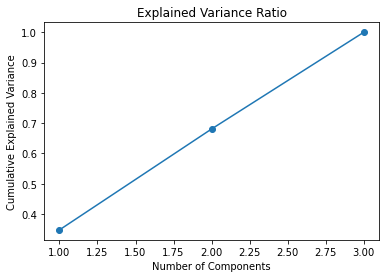

In [11]:
# PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Behaviour_problem', 'Outdoors', 'Other_cats']])
pca = PCA().fit(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()

In [12]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca_columns = [f"PC{i}" for i in range(1,3)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)
pca_complete_df = pd.concat([pca_df, df.drop('Behaviour_problem', axis=1)], axis=1)

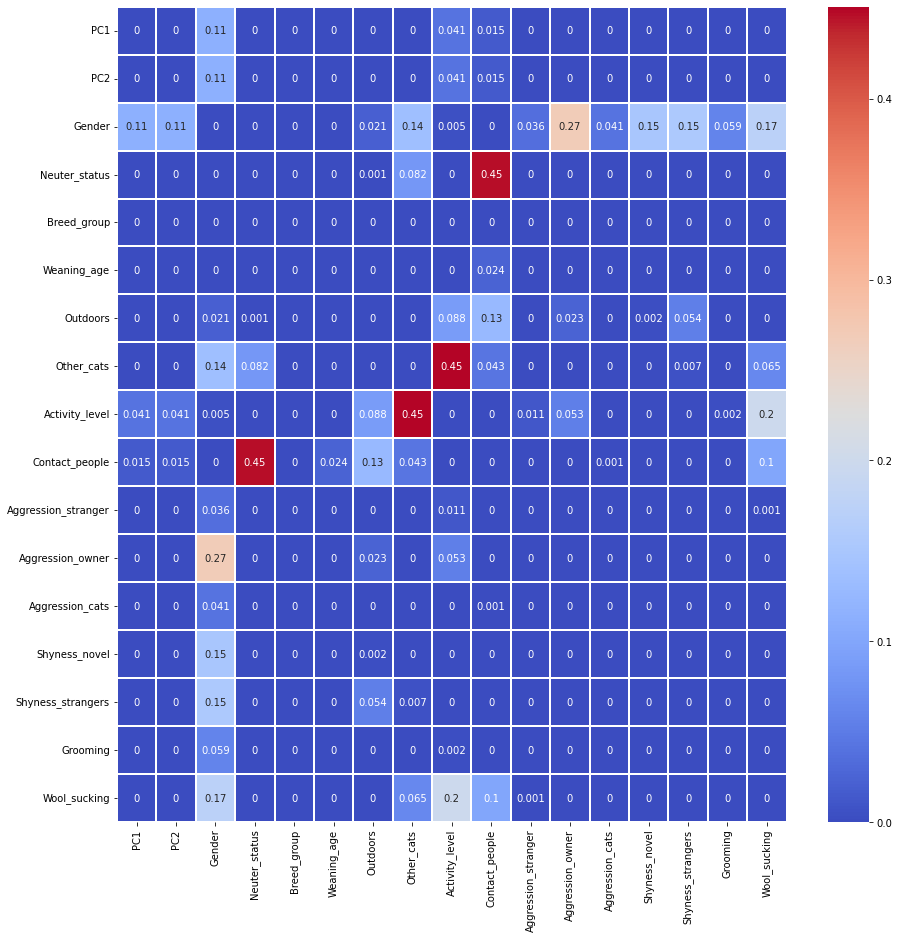

In [13]:
# extract column names
columns = pca_complete_df.drop(columns='Age').columns 
    
# create matrix 
chisqmatrix = pd.DataFrame(pca_complete_df.drop(columns='Age'), columns=columns, index=columns)
   
# set counters to 0
outercnt=0
innercnt=0
for icol in columns: # outer loop
    for jcol in columns: # inner loop
        crosstab = pd.crosstab(pca_complete_df[icol], pca_complete_df[jcol])
        stat, p, dof, expected = stats.chi2_contingency(crosstab)
        chisqmatrix.iloc[outercnt,innercnt]=round(p,3)
        cntexpected=expected[expected<5].size
        perexpected=((expected.size-cntexpected)/expected.size)*100
      
       
        if perexpected<20:
            chisqmatrix.iloc[outercnt,innercnt]=2 # low count between them suggests p-value is unreliable, do not use 
        if icol==jcol:
            chisqmatrix.iloc[outercnt,innercnt]=0.00
        innercnt=innercnt+1
    outercnt=outercnt+1
    innercnt=0

plt.subplots(figsize=(15, 15))
sns.heatmap(chisqmatrix.astype(np.float64), annot=True,linewidths=0.1, 
            cmap='coolwarm');

That looks better to me; less multicollinearity for sure. However, I want to also see if just dropping `Behaviour_problem` without adding and PC's performs similarly. Would hate to waste computing power! I'll test this below with default binary logistic regression. I also want to see if the pca set performs better than the original. 

# Training and testing 

In [14]:
# dataframe for scores amongst models

master_scores = pd.DataFrame(columns=['Model','Recall', 'F1', 'Precision', 'Accuracy'])

In [15]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
def add_to_master(model_description, y_test, y_pred, binary=True):
    '''
    Adds a new row to the running score DataFrame `master_scores` 
    and functions for adding both binary and multiclass scores. 
    '''
    global master_scores
    if binary == True:
        # Evalution Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,2), 
            'F1': round(f1, 2), 
            'Precision': round(precision, 2), 
            'Accuracy': round(accuracy, 2)}
        
        master_scores = master_scores.append(new_row, ignore_index=True)   
    
    else:
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro') # I chose macro since we have less of the sucklers 
        recall = recall_score(y_test, y_pred, average='macro')       # and I want their accuracy to be meaningful
        f1 = f1_score(y_test, y_pred, average='macro')


        # add to master_scores
        new_row = {
            'Model': model_description,
            'Recall': round(recall,2), 
            'F1': round(f1, 2), 
            'Precision': round(precision, 2), 
            'Accuracy': round(accuracy, 2)}
        master_scores = master_scores.append(new_row, ignore_index=True)
    return master_scores

## 1. Logistic Regression:
I expect binary to perform the best as I don't think we have enough data here to make a model with good predictive value. 

### 1.1 Binary + Some Feature Engineering Tests:

In [16]:
# PCA data set
pca_complete_df['ws_binary'] = pca_complete_df['Wool_sucking'].replace({1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1})
pca_complete_df.drop(columns='Wool_sucking', inplace=True)
pca_complete_df = pd.get_dummies(pca_complete_df, columns=['Breed_group'], prefix='B')
# assign X and y 
X_pca = pca_complete_df.drop(columns='ws_binary')
y_pca = pca_complete_df['ws_binary']
# train test split 
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, 
                                                                    test_size=0.3, random_state=42, stratify=y_pca)


log_PCA = LogisticRegression().fit(X_train_pca, y_train_pca)
y_pred_pca = log_PCA.predict(X_test_pca)

add_to_master('Def LogReg Binary + PCA', y_test_pca, y_pred_pca)

,Model,Recall,F1,Precision,Accuracy
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76


In [17]:
# just drop behaviour_problem
X_nbp = X_bin.drop(columns='Behaviour_problem')
X_train_nbp, X_test_nbp, y_train_nbp, y_test_nbp = train_test_split(X_nbp, y_bin, 
                                                                    test_size=0.3, random_state=42, stratify=y_bin)
log_nbp = LogisticRegression().fit(X_train_nbp, y_train_nbp)
y_pred_nbp = log_nbp.predict(X_test_nbp)

add_to_master('Def LogReg Binary + drop behavior', y_test_nbp, y_pred_nbp)

,Model,Recall,F1,Precision,Accuracy
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76
1,Def LogReg Binary + drop behavior,0.08,0.14,0.57,0.75


In [18]:
# BINARY (normal)- no scaling as logistic regression is not sensitive to magnitude 

# Instantiate and fit model
log = LogisticRegression().fit(X_train, y_train)

# Calculate Prediction, Predicted Probabilities, FPR, TPR
y_pred = log.predict(X_test)
y_pred_probs = log.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

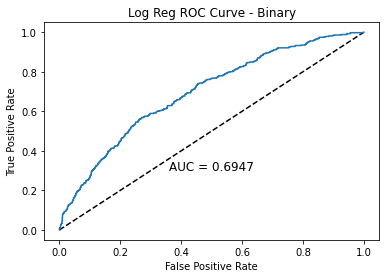

In [19]:
# Graph ROC with AUC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Binary")
plt.show();

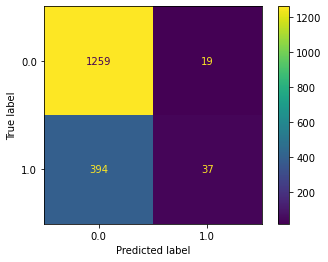

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()
plt.show();

In [21]:
# add_to_master(model_description, y_true, y_predicted)
add_to_master('Default Logistic Regression Binary', y_test, y_pred)

# check out master_scores
master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76
2,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
1,Def LogReg Binary + drop behavior,0.08,0.14,0.57,0.75


Well there's our answer! PCA doesn't seem to have helped compared to the orginal, but dropping behavior problem was definitely not the way to go. 

### 1.1.1 Binary Logistic Regression Interpretations:
The model does really well with true negatives, and pretty stinking awful at true positives. This model performs okay in the broad scope but it truly does not live up to the intended goal of being able to accurately predict if a kitty I'm looking to adopt will wool-suck or not. Actually it pretty much just predicts that they all won't. I am going to make recall my main metric to watch out for for model comparison as that is where I assume my models will continue to struggle. 

### Setting up datasets again with PCA

In [22]:
# arugula
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca_columns = [f"PC{i}" for i in range(1,3)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns)
pca_complete_df = pd.concat([pca_df, df.drop('Behaviour_problem', axis=1)], axis=1)

In [23]:
# BINARY DATASET WITH PCA 
pca_bin = pca_complete_df.copy()
pca_bin['ws_binary'] = pca_bin['Wool_sucking'].replace({1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1})
pca_bin.drop(columns='Wool_sucking', inplace=True)
pca_bin = pd.get_dummies(pca_bin, columns=['Breed_group'], prefix='B')
# assign X and y 
X_pca_bin = pca_bin.drop(columns='ws_binary')
y_pca_bin = pca_bin['ws_binary']
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X_pca_bin, y_pca_bin, 
                                                                    test_size=0.3, random_state=42, stratify=y_pca_bin)

In [24]:
# MULTICLASS DATASET WITH PCA 
pca_m = pca_complete_df.copy()
pca_m = pd.get_dummies(pca_m, columns=['Breed_group'], prefix='B')
# assign X and y 
X_pca_m = pca_m.drop(columns='Wool_sucking')
y_pca_m = pca_m['Wool_sucking']
# train test split 
X_trains, X_tests, y_trains, y_tests = train_test_split(X_pca_m, y_pca_m, 
                                                                    test_size=0.3, random_state=42, stratify=y_pca_m)

### 1.2 Multiclass:

In [25]:
# MULTICLASS 

# Instantiate model
logs = LogisticRegression(multi_class='multinomial').fit(X_trains, y_trains)

# Calculate Prediction
y_preds = logs.predict(X_tests)

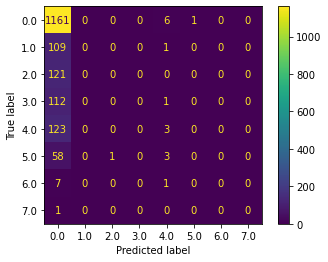

In [26]:
# Confusion Matrix 
cms = confusion_matrix(y_tests, y_preds, labels=logs.classes_)
disps = ConfusionMatrixDisplay(confusion_matrix=cms, display_labels=logs.classes_)
disps.plot()
plt.show();

As a reminder, 0 and 1 represent wool sucking behavior as never and 1-3 times in cat's lifetime. Past that is at least once/month. This did better than I thought it would, but that's really not saying much. It predicted a lot of 4's for when it did predict anything that wasn't "never."

In [27]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('Default Logistic Regression Multiclass', y_tests, y_preds, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
3,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76
2,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
1,Def LogReg Binary + drop behavior,0.08,0.14,0.57,0.75


### 1.2.1 Multiclass Logistic Regression Interpretations: 
I expected it to do poorly. Technically it did better than binary on recall but all-in-all: it sucked. I'll still try with the ordinal logistic regression since my target feature is ordinal, but I do not expect much greatness.  

### 1.3 Ordinal:

In [28]:
# ORDINAL
import statsmodels.api as sm
start_time = time.time()

# this algorithm prefers numpy arrays 
X_trains_o = X_trains.values
y_trains_o = y_trains.values

# Add constant to training
X_trains_o = sm.add_constant(X_trains_o)

# Instantiate model
ordinal_model = sm.MNLogit(y_trains_o, X_trains_o)

# Fit model
ordinal_results = ordinal_model.fit_regularized(method='l1', alpha=0.5)

end_time = time.time()
elapse_time = round((end_time - start_time), 2)
print(f"Elapsed Time {elapse_time} seconds.")

# Add constant to testing 
X_tests_o = X_tests.values
X_tests_o = sm.add_constant(X_tests_o)

# Calculate Predictions and Predicted Probabilities 
y_pred_probss = ordinal_results.predict(X_tests_o)
y_preds = np.argmax(y_pred_probss, axis=1)  # Convert predicted probabilities to class labels

Iteration limit reached    (Exit mode 9)
            Current function value: 1.0741914516150712
            Iterations: 1000
            Function evaluations: 1005
            Gradient evaluations: 1000
Elapsed Time 209.58 seconds.


C:\Users\gwent\anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 10 out of 252 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\gwent\anaconda3\lib\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\gwent\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


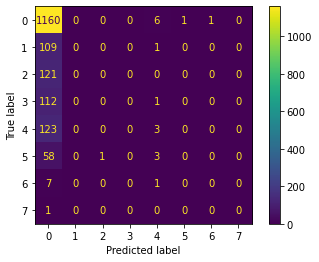

In [29]:
# Confusion Matrix
cms = confusion_matrix(y_tests, y_preds)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.show();

In [30]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('Default Ordinal Logistic Regression', y_tests, y_preds, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
3,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
4,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76
2,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
1,Def LogReg Binary + drop behavior,0.08,0.14,0.57,0.75


### 1.3.1 Ordinal Logistic Regression Interpretations:
Yeah... this didn't do much better in the multiclass context. 

## 1.4 Logistic Regression Parameter Tuning:
As expected, the binary performed the best. However, there was one common thread: all models essentially predicted each sample as the majority class. Let's quickly check out this class imbalance. There's no point in tuning a model if you're still feeding it garbage! 

In [31]:
y_bin.value_counts(normalize=True)

0.0    0.747718
1.0    0.252282
Name: ws_binary, dtype: float64

Quite the imbalance! Let's employ some resampling techniques to see if we find any improvement. Some resampling techniques include random undersampling (RUS), random oversampling (ROS), and Synthetic Minority Oversampling Technique (SMOTE). I predict the ROS will perform best as our dataset is already so small; I believe reducing datapoints even more would not be helpful. Oversampling, however, can have a tendency to overfit as it introduces redundant information. 

### 1.4.1 Resampling

In [32]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_pred = log.fit(X_resampled, y_resampled).predict(X_test)

add_to_master('SMOTE Default Logistic Regression', y_test, y_pred)

,Model,Recall,F1,Precision,Accuracy
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76
1,Def LogReg Binary + drop behavior,0.08,0.14,0.57,0.75
2,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
3,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
4,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
5,SMOTE Default Logistic Regression,0.29,0.36,0.47,0.74


In [33]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
y_pred = log.fit(X_resampled, y_resampled).predict(X_test)

add_to_master('RUS Default Logistic Regression', y_test, y_pred)

,Model,Recall,F1,Precision,Accuracy
0,Def LogReg Binary + PCA,0.09,0.15,0.67,0.76
1,Def LogReg Binary + drop behavior,0.08,0.14,0.57,0.75
2,Default Logistic Regression Binary,0.09,0.15,0.66,0.76
3,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
4,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68
5,SMOTE Default Logistic Regression,0.29,0.36,0.47,0.74
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63


In [34]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
y_pred = log.fit(X_resampled, y_resampled).predict(X_test)

add_to_master('ROS Default Logistic Regression', y_test, y_pred)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
5,SMOTE Default Logistic Regression,0.29,0.36,0.47,0.74
3,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68
4,Default Ordinal Logistic Regression,0.13,0.11,0.11,0.68


### 1.4.1.1 Interpretations of Resampling
Woah! The resampling definitely helped a lot in the recall department! Let's prep our data for regularization and RUS and then plug it into a gridsearch. I was really not sure if RUS or ROS would perform better on a dataset this small. I guess the ROS just made the new dataset too noisy and redundant. 

### 1.4.2 Scaling

In [35]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [36]:
# Logistic Regression is typically impervious to scaling...unless you do regularization, so let's scale it too!
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_resampled)
X_train_scaled = scaler.transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Grid Search for Binary Logistic Regression


# timing this process
start_time = time.time()


param_grid = {
    'C': [None, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': [None, 'l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'max_iter' : [100, 500, 1000]
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_resampled)

end_time = time.time()
elapsed_time = end_time - start_time

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

Best Hyperparameters:  {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  0.6312595438648343
Elapsed Time: 9.55 seconds


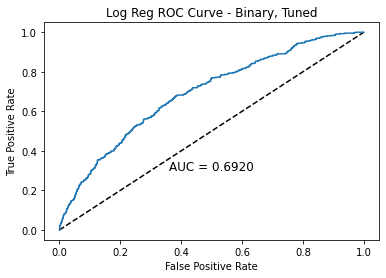

In [38]:
# re-plot w tuned parameters
log_tuned = grid_search.best_estimator_
log_tuned.fit(X_train_scaled, y_resampled)

y_pred_tuned = log_tuned.predict(X_test_scaled)
y_pred_probs_tuned = log_tuned.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_tuned)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs_tuned):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve - Binary, Tuned")
plt.show();

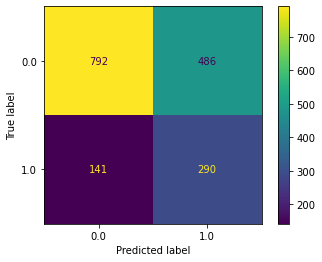

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned, labels=log_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_tuned.classes_)
disp.plot()
plt.show();

In [40]:
# add_to_master(model_description, binary=True, y_true, y_predicted, df)
add_to_master('Scaled GridSearch Log Reg Binary', y_test, y_pred_tuned, binary=True)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
5,SMOTE Default Logistic Regression,0.29,0.36,0.47,0.74
3,Default Logistic Regression Multiclass,0.13,0.11,0.11,0.68


### Conclusion to Log Reg:
From default, no pca, unscaled plain 'ol `log` we've made leaps in bounds to `log_tuned`. It is for sure winning the game so far.  
Winning Model Features:  
* PCA on `Behaviour_problem`, `Outdoors`, `Other_cats`, with `n_components=2` and then drop `Behavior_problem`
* Binary
* MinMax Scaled 1-5 
* Logistic Regression 
    * Best Hyperparameters:  {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

### Adding Resampling Method:
Let's prep our dataset so we can test it with other models.

In [41]:
rus = RandomUnderSampler()

# BINARY RESAMPLED
X_train, y_train = rus.fit_resample(X_train, y_train)

# MULTICLASS RESAMPLED 
X_trains, y_trains = rus.fit_resample(X_trains, y_trains)

## 2. Random Forest:
This algorithm is also not sensitive to magnitude so I will not be scaling. I would think Random Forest would be my best bet at muticlass of the three, but I still don't have high hopes. 

### 2.1 Binary:

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
# binary run

# instantiate the model 
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# predict and predicted probs 
y_pred = rf.predict(X_test)
y_pred_probs = rf.predict_proba(X_test)[:,1]

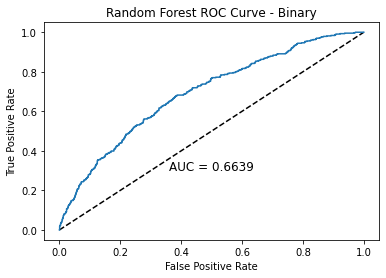

In [44]:
# ROC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve - Binary")
plt.show();

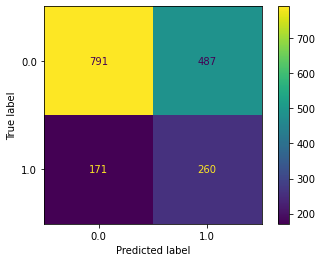

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show();

In [46]:
# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master('Default Random Forest Binary', y_test, y_pred, binary=True)

master_scores.sort_values('Recall', ascending=False).head()


,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
9,Default Random Forest Binary,0.6,0.44,0.35,0.61
5,SMOTE Default Logistic Regression,0.29,0.36,0.47,0.74


Running Best Scores (Log Binary Default:`log`):  
Accuracy: 0.7583382094792276  
Precision: 0.6607142857142857  
Recall: 0.08584686774941995  
F1-score: 0.1519507186858316  

### 2.1.1 Binary RF Interpretations:
Fairly comparable to`log`. Recall is improved (at the sake of precision) but I'm more concerned about recall. A good chunk (~30) more of false positives, which is better than just automatically classifying everyone as a non-sucker. However, not a huge shift in true positives (+5)(yet a shift in the right direcction nonetheless). It'll be interesting to see how the multiclass performs. 

### 2.2 Multiclass:

In [47]:
# multiclass run

# instantiate the model
rfs = RandomForestClassifier()

# fit the model
rfs.fit(X_trains, y_trains)

# predicted and predicted probs
y_preds = rfs.predict(X_tests)
y_pred_probss = rfs.predict_proba(X_tests)[:,1]

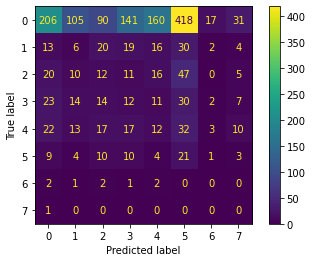

In [48]:
# Confusion Matrix
cms = confusion_matrix(y_tests, y_preds)
disps = ConfusionMatrixDisplay(confusion_matrix=cms)
disps.plot()
plt.show();

In [49]:
# add_to_master(model_description, y_true, y_predicted, binary=True)
add_to_master('Default Random Forest Multiclass', y_tests, y_preds, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
9,Default Random Forest Binary,0.6,0.44,0.35,0.61
5,SMOTE Default Logistic Regression,0.29,0.36,0.47,0.74


### 2.2.1 RF Multiclass Interpretations:
I actually think this model isn't *awful* in the multiclass context, but it's really not great. 

## 2.3 Random Forest Hyperparameter Tuning:
On the binary model, of course. 

In [50]:
start_time = time.time()

param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'random_state': [42],
    'max_features': ['auto', 'log2', None],
    'class_weight': [None, 'balanced']    
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'class_weight': None, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}
Best Score:  0.6103541697453327
Elapsed Time: 119.89 seconds


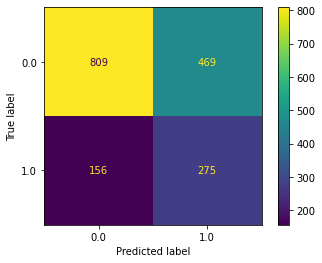

In [51]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show();

In [52]:
# add_to_master(model_description, y_true, y_predicted)
add_to_master('Tuned Random Forest Binary', y_test, y_pred, binary=True)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
11,Tuned Random Forest Binary,0.64,0.47,0.37,0.63
9,Default Random Forest Binary,0.6,0.44,0.35,0.61


## KNN:
KNN is a distance-based algorithm, so I would assume scaling would increase performance. I still don't think I have enough data for multiclass prediction.

In [53]:
from sklearn.neighbors import KNeighborsClassifier

### Binary

In [54]:
# KNN - BINARY

# instantiate model
knn = KNeighborsClassifier()

# I'm not sure what a good value for k would be, so let's start off with parameter tuning this time 
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')

# Fit it
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_probs = best_model.predict_proba(X_test)[:,1]

Best Parameters: {'n_neighbors': 5}


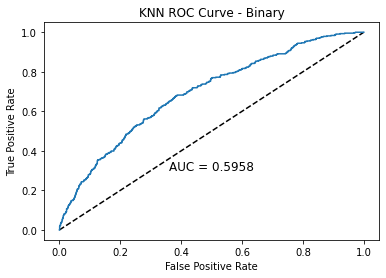

In [55]:
# ROC 
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN ROC Curve - Binary")
plt.show();

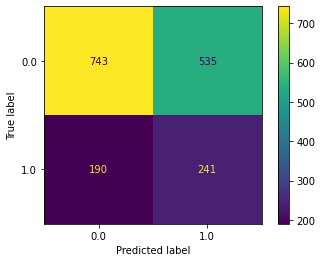

In [56]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()
plt.show();

In [57]:
# add_to_master(model_description, y_true, y_predicted)
add_to_master('Binary KNN k=3', y_test, y_pred, binary=True)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
11,Tuned Random Forest Binary,0.64,0.47,0.37,0.63
9,Default Random Forest Binary,0.6,0.44,0.35,0.61


### Binary KNN - Scaled

In [58]:
# scale data
scaler = MinMaxScaler(feature_range=(0,5))

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# instantiate model
knn_scaled = KNeighborsClassifier()

# instantiate grid search
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_scaled, param_grid, cv=5, scoring='recall')

# Fit it
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_scaled = grid_search.best_estimator_
y_pred = best_scaled.predict(X_test_scaled)
y_pred_probs = best_scaled.predict_proba(X_test_scaled)[:,1]

Best Parameters: {'n_neighbors': 7}


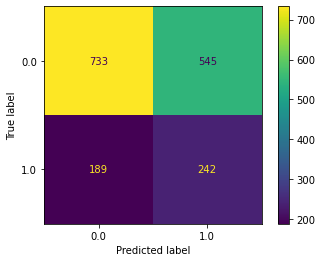

In [60]:
# Confusion Matrix
cm_scaled = confusion_matrix(y_test, y_pred, labels=best_scaled.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_scaled, display_labels=best_scaled.classes_)
disp.plot()
plt.show();

In [61]:
# add_to_master(model_description, y_true, y_predicted)
add_to_master('Binary KNN k=3 ALL scaled', y_test, y_pred, binary=True)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
11,Tuned Random Forest Binary,0.64,0.47,0.37,0.63
9,Default Random Forest Binary,0.6,0.44,0.35,0.61


### Scaling just the age column:

In [62]:
X_age_scaled = X_train.copy()
X_age_scaled_test = X_test.copy()

scaler_age = MinMaxScaler(feature_range=(0,5))
scaler_age.fit(X_age_scaled['Age'].values.reshape(-1,1))

X_age_scaled['Age'] = scaler_age.transform(X_age_scaled['Age'].values.reshape(-1, 1))
X_age_scaled_test['Age'] = scaler_age.transform(X_age_scaled_test['Age'].values.reshape(-1,1))

In [63]:
X_age_scaled.head()

,PC1,PC2,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,...,B_MCO,B_NFO,B_ORI,B_PER,B_RAG,B_RUS,B_SBI,B_SIB,B_TUV,B_other
0,-0.439269,-0.400249,0.398902,1,0,4,2,1,4,3,...,0,0,0,0,1,0,0,0,0,0
1,-1.430029,3.045112,1.258653,1,1,4,1,1,4,4,...,0,0,0,0,0,0,0,0,1,0
2,-0.806467,-0.429398,0.733021,2,1,4,1,1,3,1,...,0,0,0,0,0,0,0,1,0,0
3,0.295128,-0.341950,0.456512,2,1,5,4,1,4,4,...,0,1,0,0,0,0,0,0,0,0
4,-0.072070,-0.371099,0.130331,1,1,4,3,1,5,4,...,1,0,0,0,0,0,0,0,0,0


In [64]:
# instantiate model
knn_scaled = KNeighborsClassifier()

# instantiate grid search
param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_scaled, param_grid, cv=5, scoring='recall')

# Fit it
grid_search.fit(X_age_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)

# Predicted and predicted probabilities
best_scaled = grid_search.best_estimator_
y_pred = best_scaled.predict(X_age_scaled_test)
y_pred_probs = best_scaled.predict_proba(X_age_scaled_test)[:,1]

Best Parameters: {'n_neighbors': 9}


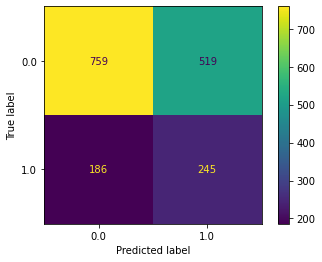

In [65]:
# Confusion Matrix
cm_scaled = confusion_matrix(y_test, y_pred, labels=best_scaled.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_scaled, display_labels=best_scaled.classes_)
disp.plot()
plt.show();

In [66]:
# add_to_master(model_description, y_true, y_predicted)
add_to_master('Binary KNN k=3 AGE Scaled', y_test, y_pred, binary=True)

master_scores.sort_values('Recall', ascending=False).head()

,Model,Recall,F1,Precision,Accuracy
8,Scaled GridSearch Log Reg Binary,0.67,0.48,0.37,0.63
6,RUS Default Logistic Regression,0.64,0.47,0.37,0.63
7,ROS Default Logistic Regression,0.64,0.47,0.37,0.63
11,Tuned Random Forest Binary,0.64,0.47,0.37,0.63
9,Default Random Forest Binary,0.6,0.44,0.35,0.61


### Multiclass

In [67]:
# multiclass KNN 

knn_m = KNeighborsClassifier()

param_grid = {'n_neighbors':[3, 5, 7, 9]}
grid_search = GridSearchCV(knn_m, param_grid, cv=5, scoring='recall')
grid_search.fit(X_trains, y_trains)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score: ", best_score)

best_multi_knn = grid_search.best_estimator_
y_pred = best_multi_knn.predict(X_tests)
y_pred_probs = best_multi_knn.predict_proba(X_tests)

ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_tests, y_pred, labels=best_multi_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_multi_knn.classes_)
disp.plot()
plt.show();

In [ ]:
# add_to_master(model_description, y_true, y_predicted)
add_to_master('Multiclass KNN k=3', y_test, y_pred, binary=False)

master_scores.sort_values('Recall', ascending=False).head()

As to be expected! Multiclass is still not doing so hot with this small of a set. 

### Question: When you reassociate the original class pre-binarization, which ones is it getting wrong most often?

X, y = df_bin.drop(columns='ws_binary'), df_bin['ws_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X_train, y_train)

rf_rus = RandomForestClassifier()

rf_rus.fit(X_rus, y_rus)

y_pred_rus = rf_rus.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
precision = precision_score(y_test, y_pred_rus)
recall = recall_score(y_test, y_pred_rus)
f1 = f1_score(y_test, y_pred_rus)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred_rus, labels=rf_rus.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_rus.classes_)
disp.plot()
plt.show();

In [153]:
test_pred = pd.DataFrame({'True': y_test})
test_pred['Predicted'] = y_pred_rus

In [154]:
test_pred

,True,Predicted
3165,1.0,1.0
565,1.0,1.0
5407,1.0,1.0
2445,0.0,0.0
512,0.0,0.0
...,...,...
2569,0.0,0.0
4468,0.0,0.0
832,0.0,0.0
3694,0.0,0.0


In [155]:
# reassociate original variable
final = test_pred.join(df_multi['Wool_sucking'])
final

,True,Predicted,Wool_sucking
3165,1.0,1.0,2.0
565,1.0,1.0,5.0
5407,1.0,1.0,2.0
2445,0.0,0.0,0.0
512,0.0,0.0,0.0
...,...,...,...
2569,0.0,0.0,0.0
4468,0.0,0.0,0.0
832,0.0,0.0,0.0
3694,0.0,0.0,0.0


In [157]:
# should be 619
mismatched = final[final['Predicted'] != final['True']]
mismatched

,True,Predicted,Wool_sucking
4114,0.0,1.0,0.0
4066,1.0,0.0,2.0
3644,1.0,0.0,4.0
413,0.0,1.0,0.0
3607,1.0,0.0,3.0
...,...,...,...
2388,0.0,1.0,0.0
4934,0.0,1.0,0.0
774,0.0,1.0,0.0
5205,0.0,1.0,0.0


In [158]:
should_be_0 = mismatched[mismatched['True'] == 0]
should_be_1 = mismatched[mismatched['True'] == 1]

In [159]:
should_be_0['Wool_sucking'].value_counts()

0.0    447
1.0     64
Name: Wool_sucking, dtype: int64

In [160]:
should_be_1['Wool_sucking'].value_counts()

2.0    49
3.0    37
4.0    36
5.0    24
6.0     2
Name: Wool_sucking, dtype: int64

In [161]:
mismatched['Wool_sucking'].value_counts()

0.0    447
1.0     64
2.0     49
3.0     37
4.0     36
5.0     24
6.0      2
Name: Wool_sucking, dtype: int64

# Recap:

Only the binary classifiers did a good job! We tried Logistic Regression, a Random Forest, and KNN.

We will be carrying on with the following model: 
`log_rus` (LogisticRegression with default parameters trained on randomly undersampled data.)  

It has the highest recall, which is important because initial modelling suggested that would be my dataset's weakness. 

In [ ]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

m = smf.ols(formula = 'PRICE ~ AGE + TAX',data = bos).fit()
print(m.summary())

In [162]:
master_scores.sort_values('Recall', ascending=False)

,Model,Recall,F1,Precision,Accuracy
11,Random Forest RUS Binary,0.67,0.47,0.36,0.62
24,"""Tuned"" Binary LogReg RUS Threshold Adjusted",0.65,0.47,0.36,0.62
23,"""Hand-Tuned"" Binary LogReg RUS",0.65,0.47,0.36,0.62
14,Log Reg Binary RUS,0.64,0.46,0.36,0.63
13,Log Reg Binary ROS,0.64,0.46,0.37,0.63
20,Binary KNN k=3 RUS,0.54,0.41,0.33,0.6
21,Binary KNN k=3 ROS,0.47,0.38,0.32,0.61
10,Random Forest ROS Binary,0.34,0.37,0.41,0.71
12,Log Reg Binary SMOTE,0.29,0.36,0.46,0.74
8,Hand-Tuned Random Forest Binary,0.29,0.36,0.45,0.73
